In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import MultiViewMultiLabelMetaDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
# loss function and optimizer
# train and test functions
from src.train import multitask_train
from src.test import test_multitask
import random 
import pandas as pd

In [2]:
def set_random_seeds(seed):
    random.seed(seed)          # Python random module
    np.random.seed(seed)       # NumPy random module
    torch.manual_seed(seed)    # PyTorch CPU random generator
    torch.cuda.manual_seed(seed)  # PyTorch GPU random generator (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.benchmark = False    # Avoid non-deterministic algorithms

In [3]:
set_random_seeds(42)
# Model parameters.
EPOCHS = 10
EMBED_DIM = 512
NUM_ENCODER_LAYERS = 1 #4
NUM_HEADS = 8

# Constants:
DATASET = 'C:\\Users\\preet\\Documents\\BRSET\\data\\'
SAVE_DIR = 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\TEST\\metafusion_dr\\'
DOWNLOAD = False
SHAPE = (224, 224)
#IMAGES = os.path.join(DATASET, 'fundus2')
IMAGES = os.path.join(DATASET, 'resized_fundus_photos')
#LABEL = 'final_icdr'
TEST_SIZE = 0.3 #0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'dr_labels.csv')
IMG_COL_LIST=['file_1']


NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

LABEL_COL_LIST = ['DR_ICDR2'] 
LABEL = LABEL_COL_LIST[0]
META_COL_LIST = ['patient_sex','patient_age_bin','hyp','bin_db_time']

BACKBONE = 'resnet18'
LOAD_PRETRAINED = False
MODE = 'fine_tune'
backbone_mode = 'fine_tune'
PARTITION_BY_PATIENT = True
HIDDEN = [128, 128]
num_classes = 2

BATCH_SIZE = 16 
NUM_WORKERS = 8 

LOSS = None
OPTIMIZER = 'adam'

USE_RELU = True #addition of RELU for final model classification, between the two linear layers after the backbone
# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5 #0.5e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [4]:
df = pd.read_csv(LABELS_PATH)


In [5]:
def check_output_cnt(df, labels):
    for label in labels:
        print(label, sum(df[label])/len(df))
   

Partitioning by patient
Train data shape: (345, 2)
Test data shape: (149, 2)


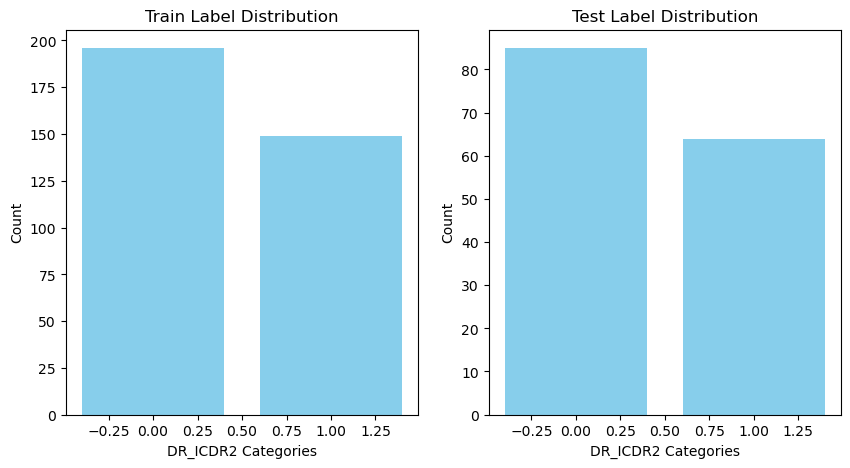

Getting validation set...
Train data shape: (74, 2)
Test data shape: (75, 2)


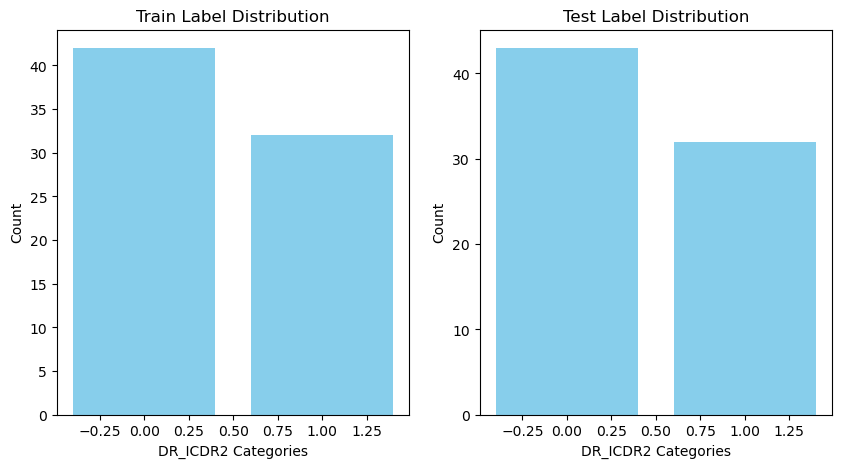

(135, 41)
(141, 41)


In [6]:
if PARTITION_BY_PATIENT:
    print('Partitioning by patient')
    ## LOGIC for partitioning by patient
    # Separate out patients for training and test
    k = 2
    df_subsampled = df.iloc[::k]
    df_patient = df_subsampled[['patient_id',LABEL]]
    df_patient.head()
    #split=0.2
    df_patient_train, df_patient_test = split_data(df_patient, LABEL, TEST_SIZE, undersample=False, random_state = 42)
    # Now find all rows in df for the patients in df_train
    train_patients = list(df_patient_train['patient_id'])
    
    df_train = df[df['patient_id'].isin(train_patients)]
    
    print('Getting validation set...')
    
    df_patient_test, df_patient_val = split_data(df_patient_test, LABEL, 0.50,random_state = 42)
    test_patients = list(df_patient_test['patient_id'])
    df_test = df[df['patient_id'].isin(test_patients)]
    print(df_test.shape)

    val_patients = list(df_patient_val['patient_id'])
    df_val = df[df['patient_id'].isin(val_patients)]
    print(df_val.shape)
else:
    df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False, random_state=42)
    df_test, df_val = split_data(df_test, LABEL, 0.50,random_state = 42)






In [7]:
# Define the target image shape
SHAPE = (256, 256)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image horizontally  

])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),

])


if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In init
['file_1']
torch.Size([659, 4])
In init
['file_1']
torch.Size([135, 4])
In init
['file_1']
torch.Size([141, 4])


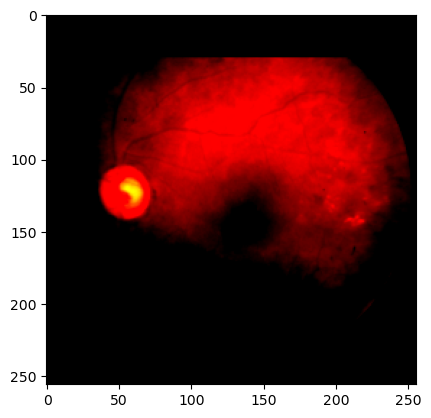

In [8]:
train_dataset = MultiViewMultiLabelMetaDataset(
    df_train, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,  
    transform=train_transforms,
    meta_only=False,
    num_views_per_image=1
)

test_dataset = MultiViewMultiLabelMetaDataset(
    df_test, 
    
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,  
    transform=test_transform,
    meta_only=False,
    num_views_per_image=1

)

val_dataset = MultiViewMultiLabelMetaDataset(
    df_val, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,   
    transform=test_transform,
    meta_only=False,
    num_views_per_image=1

)
NUM_WORKERS=4
v = test_dataset[41]
images = v['image']
for i in range(len(images)):
    plt.imshow(images[i].permute(1, 2, 0)) 
    plt.show()

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)


In [9]:
class FusionLayer(torch.nn.Module):
    def __init__(self, x1_dim, x2_dim):
        super(FusionLayer, self).__init__()
        self.W = nn.Linear(x1_dim, x2_dim)
    
    def forward(self,x1, x2):
        # Project x2 to x1's space
        x2= self.W(x2)
        # Element wise mul
        z = x1*x2
        z = F.tanh(z)
        return x1*z
        
class MetaFusionModel(nn.Module):
    def __init__(self, backbone,num_metadata_features, embed_dim, num_layers, num_heads, num_patch, vision_emb_dim, num_labels):
        super(MetaFusionModel, self).__init__()
        self.backbone = backbone
        self.num_patch = num_patch
        self.vision_emb_dim = vision_emb_dim
        self.meta_embed_dim = 512
        self.emb =nn.ModuleList([])
        self.metaToimg1_gates =nn.ModuleList([])
        self.img1Tometa_gates =nn.ModuleList([])

        self.num_metadata_features = num_metadata_features
        self.cls_emb  = torch.nn.Parameter(torch.randn(1, 1,embed_dim))
        #self.cls_emb.requires_grad_(False)  
        self.embed_dim = embed_dim
        for i in range(num_metadata_features):
            self.emb.append(nn.Embedding(16, self.meta_embed_dim))
            self.metaToimg1_gates.append(FusionLayer(self.embed_dim, self.meta_embed_dim))
        # For fusing images
        for i in range(num_metadata_features):
            self.img1Tometa_gates.append(FusionLayer(self.meta_embed_dim, self.embed_dim))

        self.output_linear =nn.ModuleList([])
        for i in range(num_labels):
            self.output_linear.append(nn.Linear(self.meta_embed_dim*self.num_metadata_features+embed_dim, 2))

        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.backboneLinear = nn.Linear(self.vision_emb_dim,embed_dim) # 1024 for base, 768 for tiny
        
    
    def forward(self, x_list, x_meta):
        features=[]
        B = x_list[0].size()[0]
        z = self.backbone(x_list[0])
        z = self.dropout(z)
        # print("z size", z.size()) #2 x 1024 x 4 x 4
        feat=self.backboneLinear(z)  # b x 1 x 512
            

        y = [None] * self.num_metadata_features
        for i in range(self.num_metadata_features):
            y[i] = self.emb[i](x_meta[:,i])
            y[i] = self.dropout(y[i])
        
    

        x1 = feat
        for i in range(self.num_metadata_features):
            x1=x1+self.metaToimg1_gates[i](feat,y[i])


        #updating the metadata embeddings with respect to other embeddings
        for i in range(self.num_metadata_features):
            y[i]=y[i] +  self.img1Tometa_gates[i](y[i],feat)
    
       
        
          
        x_out = torch.cat([x1]+y, dim=1)
        x_out = self.dropout2(x_out)

        out = [0]*len(self.output_linear)
        for i in range(len(self.output_linear)):
            out[i]=self.output_linear[i](x_out)       
       

        return out       
    

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)

model = MetaFusionModel(
    backbone = backbone_model,
    num_metadata_features = len(META_COL_LIST),
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS,
    num_patch=1, 
    vision_emb_dim=512, #2048 (resnet50)
    num_labels = len(LABEL_COL_LIST)
)


In [11]:
# Now make sure that loss can be calculated correctly
# Then change model to have multiple heads
criterion_list = []

for i in range(len(LABEL_COL_LIST)):
    
    class_indices = train_dataloader.dataset.df_labels.numpy()[:,i]
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32) 
    print(class_weights)
    criterion =  nn.CrossEntropyLoss(weight=class_weights).to(device)
    criterion_list.append(criterion)

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

tensor([0.8858, 1.1481])


In [12]:
 # To load pre-trained model          
if LOAD_PRETRAINED:
    state_dict = torch.load(SAVE_DIR + 'pretrain\\pretrained_model_best.pth')
    # Pop keys that do not have any useful information from pre-training.
    keys_to_pop=['emb.0.weight', 'emb.1.weight', 'output_linear.0.weight', 'output_linear.0.bias', 'output_linear.1.weight', 'output_linear.1.bias','output_linear.2.weight', 'output_linear.2.bias', 'output_linear.3.weight', 'output_linear.3.bias','output_linear.4.weight', 'output_linear.4.bias'] 
    for key in keys_to_pop:    
        state_dict.pop(key,None)
    model.load_state_dict(state_dict, strict=False)


taskList = [0]
model = multitask_train(model,taskList, train_dataloader, val_dataloader,test_dataloader,
              criterion_list, optimizer, scheduler=scheduler, num_epochs=num_epochs, save=True, save_dir = SAVE_DIR,device="cuda", 
              backbone=f'convnextv2_binary',patience=100) 

AMP True


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:24<00:00,  1.74it/s]


Epoch 1
Train loss 0.777, F1 0.500, Acc 0.505, BA 0.500
cm[[202 170]
 [156 131]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 1
Val loss 0.652, F1 0.623, Acc 0.624, BA 0.634
cm[[48 35]
 [18 40]]
Mean f1 score 0.623
Mean ba score 0.634


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.33it/s]


Test loss 0.613, F1 0.607, Acc 0.607, BA 0.609
cm[[42 30]
 [23 40]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.83it/s]


Epoch 2
Train loss 0.620, F1 0.653, Acc 0.657, BA 0.654
cm[[253 119]
 [107 180]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.74it/s]


Epoch 2
Val loss 0.591, F1 0.709, Acc 0.709, BA 0.724
cm[[53 30]
 [11 47]]
Mean f1 score 0.709
Mean ba score 0.724


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.30it/s]


Test loss 0.527, F1 0.732, Acc 0.733, BA 0.741
cm[[45 27]
 [ 9 54]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.24it/s]


Epoch 3
Train loss 0.529, F1 0.713, Acc 0.715, BA 0.716
cm[[263 109]
 [ 79 208]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.63it/s]


Epoch 3
Val loss 0.538, F1 0.768, Acc 0.773, BA 0.771
cm[[65 18]
 [14 44]]
Mean f1 score 0.768
Mean ba score 0.771


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 15.90it/s]


Test loss 0.453, F1 0.807, Acc 0.807, BA 0.808
cm[[58 14]
 [12 51]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.78it/s]


Epoch 4
Train loss 0.513, F1 0.745, Acc 0.750, BA 0.744
cm[[292  80]
 [ 85 202]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.06it/s]


Epoch 4
Val loss 0.514, F1 0.743, Acc 0.752, BA 0.742
cm[[66 17]
 [18 40]]
Mean f1 score 0.743
Mean ba score 0.742


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.70it/s]


Test loss 0.409, F1 0.813, Acc 0.815, BA 0.812
cm[[61 11]
 [14 49]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.80it/s]


Epoch 5
Train loss 0.425, F1 0.799, Acc 0.803, BA 0.797
cm[[312  60]
 [ 70 217]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.13it/s]


Epoch 5
Val loss 0.502, F1 0.772, Acc 0.780, BA 0.772
cm[[68 15]
 [16 42]]
Mean f1 score 0.772
Mean ba score 0.772


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.19it/s]


Test loss 0.384, F1 0.827, Acc 0.830, BA 0.825
cm[[64  8]
 [15 48]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.81it/s]


Epoch 6
Train loss 0.408, F1 0.822, Acc 0.824, BA 0.824
cm[[307  65]
 [ 51 236]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.33it/s]


Epoch 6
Val loss 0.491, F1 0.776, Acc 0.787, BA 0.773
cm[[71 12]
 [18 40]]
Mean f1 score 0.776
Mean ba score 0.773


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 17.11it/s]


Test loss 0.369, F1 0.834, Acc 0.837, BA 0.831
cm[[66  6]
 [16 47]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 16.06it/s]


Epoch 7
Train loss 0.405, F1 0.817, Acc 0.821, BA 0.816
cm[[317  55]
 [ 63 224]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.00it/s]


Epoch 7
Val loss 0.474, F1 0.783, Acc 0.794, BA 0.779
cm[[72 11]
 [18 40]]
Mean f1 score 0.783
Mean ba score 0.779


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.39it/s]


Test loss 0.352, F1 0.849, Acc 0.852, BA 0.847
cm[[66  6]
 [14 49]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.55it/s]


Epoch 8
Train loss 0.386, F1 0.817, Acc 0.819, BA 0.817
cm[[310  62]
 [ 57 230]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.02it/s]


Epoch 8
Val loss 0.464, F1 0.806, Acc 0.816, BA 0.802
cm[[73 10]
 [16 42]]
Mean f1 score 0.806
Mean ba score 0.802


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.70it/s]


Test loss 0.353, F1 0.821, Acc 0.822, BA 0.820
cm[[61 11]
 [13 50]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.69it/s]


Epoch 9
Train loss 0.352, F1 0.840, Acc 0.842, BA 0.841
cm[[317  55]
 [ 49 238]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.13it/s]


Epoch 9
Val loss 0.459, F1 0.829, Acc 0.837, BA 0.825
cm[[74  9]
 [14 44]]
Mean f1 score 0.829
Mean ba score 0.825


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.98it/s]


Test loss 0.339, F1 0.858, Acc 0.859, BA 0.857
cm[[64  8]
 [11 52]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.53it/s]


Epoch 10
Train loss 0.379, F1 0.854, Acc 0.857, BA 0.852
cm[[332  40]
 [ 54 233]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.13it/s]


Epoch 10
Val loss 0.451, F1 0.823, Acc 0.830, BA 0.822
cm[[72 11]
 [13 45]]
Mean f1 score 0.823
Mean ba score 0.822


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.64it/s]


Test loss 0.332, F1 0.844, Acc 0.844, BA 0.843
cm[[62 10]
 [11 52]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.89it/s]


Epoch 11
Train loss 0.345, F1 0.840, Acc 0.842, BA 0.842
cm[[315  57]
 [ 47 240]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.45it/s]


Epoch 11
Val loss 0.443, F1 0.799, Acc 0.809, BA 0.796
cm[[72 11]
 [16 42]]
Mean f1 score 0.799
Mean ba score 0.796


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.67it/s]


Test loss 0.319, F1 0.858, Acc 0.859, BA 0.858
cm[[63  9]
 [10 53]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.83it/s]


Epoch 12
Train loss 0.342, F1 0.859, Acc 0.862, BA 0.859
cm[[329  43]
 [ 48 239]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.52it/s]


Epoch 12
Val loss 0.436, F1 0.827, Acc 0.830, BA 0.832
cm[[68 15]
 [ 9 49]]
Mean f1 score 0.827
Mean ba score 0.832


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.16it/s]


Test loss 0.313, F1 0.837, Acc 0.837, BA 0.839
cm[[58 14]
 [ 8 55]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.71it/s]


Epoch 13
Train loss 0.319, F1 0.881, Acc 0.883, BA 0.879
cm[[339  33]
 [ 44 243]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.35it/s]


Epoch 13
Val loss 0.443, F1 0.793, Acc 0.794, BA 0.805
cm[[62 21]
 [ 8 50]]
Mean f1 score 0.793
Mean ba score 0.805


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.64it/s]


Test loss 0.320, F1 0.844, Acc 0.844, BA 0.849
cm[[56 16]
 [ 5 58]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 16.02it/s]


Epoch 14
Train loss 0.291, F1 0.879, Acc 0.882, BA 0.876
cm[[341  31]
 [ 47 240]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.31it/s]


Epoch 14
Val loss 0.445, F1 0.785, Acc 0.787, BA 0.796
cm[[62 21]
 [ 9 49]]
Mean f1 score 0.785
Mean ba score 0.796


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.28it/s]


Test loss 0.323, F1 0.844, Acc 0.844, BA 0.847
cm[[58 14]
 [ 7 56]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.66it/s]


Epoch 15
Train loss 0.296, F1 0.858, Acc 0.860, BA 0.859
cm[[324  48]
 [ 44 243]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.26it/s]


Epoch 15
Val loss 0.430, F1 0.815, Acc 0.823, BA 0.813
cm[[72 11]
 [14 44]]
Mean f1 score 0.815
Mean ba score 0.813


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.61it/s]


Test loss 0.297, F1 0.866, Acc 0.867, BA 0.867
cm[[62 10]
 [ 8 55]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.34it/s]


Epoch 16
Train loss 0.279, F1 0.890, Acc 0.892, BA 0.890
cm[[337  35]
 [ 36 251]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.45it/s]


Epoch 16
Val loss 0.424, F1 0.827, Acc 0.837, BA 0.820
cm[[76  7]
 [16 42]]
Mean f1 score 0.827
Mean ba score 0.820


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 15.41it/s]


Test loss 0.287, F1 0.866, Acc 0.867, BA 0.866
cm[[63  9]
 [ 9 54]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.44it/s]


Epoch 17
Train loss 0.292, F1 0.866, Acc 0.868, BA 0.866
cm[[329  43]
 [ 44 243]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.68it/s]


Epoch 17
Val loss 0.444, F1 0.832, Acc 0.844, BA 0.823
cm[[78  5]
 [17 41]]
Mean f1 score 0.832
Mean ba score 0.823


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.76it/s]


Test loss 0.296, F1 0.873, Acc 0.874, BA 0.872
cm[[65  7]
 [10 53]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 12.47it/s]


Epoch 18
Train loss 0.266, F1 0.879, Acc 0.880, BA 0.880
cm[[328  44]
 [ 35 252]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.22it/s]


Epoch 18
Val loss 0.442, F1 0.838, Acc 0.844, BA 0.836
cm[[73 10]
 [12 46]]
Mean f1 score 0.838
Mean ba score 0.836


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.03it/s]


Test loss 0.289, F1 0.866, Acc 0.867, BA 0.868
cm[[61 11]
 [ 7 56]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.63it/s]


Epoch 19
Train loss 0.299, F1 0.880, Acc 0.883, BA 0.877
cm[[343  29]
 [ 48 239]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.33it/s]


Epoch 19
Val loss 0.445, F1 0.823, Acc 0.830, BA 0.822
cm[[72 11]
 [13 45]]
Mean f1 score 0.823
Mean ba score 0.822


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.98it/s]


Test loss 0.284, F1 0.866, Acc 0.867, BA 0.868
cm[[61 11]
 [ 7 56]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.52it/s]


Epoch 20
Train loss 0.251, F1 0.898, Acc 0.900, BA 0.899
cm[[337  35]
 [ 31 256]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.68it/s]


Epoch 20
Val loss 0.433, F1 0.837, Acc 0.844, BA 0.834
cm[[74  9]
 [13 45]]
Mean f1 score 0.837
Mean ba score 0.834


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.70it/s]


Test loss 0.299, F1 0.866, Acc 0.867, BA 0.867
cm[[62 10]
 [ 8 55]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.98it/s]


Epoch 21
Train loss 0.256, F1 0.895, Acc 0.897, BA 0.895
cm[[339  33]
 [ 35 252]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.52it/s]


Epoch 21
Val loss 0.432, F1 0.836, Acc 0.844, BA 0.831
cm[[75  8]
 [14 44]]
Mean f1 score 0.836
Mean ba score 0.831


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.54it/s]


Test loss 0.297, F1 0.859, Acc 0.859, BA 0.860
cm[[61 11]
 [ 8 55]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 16.02it/s]


Epoch 22
Train loss 0.252, F1 0.892, Acc 0.894, BA 0.892
cm[[336  36]
 [ 34 253]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.08it/s]


Epoch 22
Val loss 0.430, F1 0.828, Acc 0.837, BA 0.822
cm[[75  8]
 [15 43]]
Mean f1 score 0.828
Mean ba score 0.822


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.39it/s]


Test loss 0.273, F1 0.874, Acc 0.874, BA 0.874
cm[[63  9]
 [ 8 55]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.67it/s]


Epoch 23
Train loss 0.244, F1 0.898, Acc 0.900, BA 0.899
cm[[337  35]
 [ 31 256]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.93it/s]


Epoch 23
Val loss 0.443, F1 0.842, Acc 0.851, BA 0.835
cm[[77  6]
 [15 43]]
Mean f1 score 0.842
Mean ba score 0.835


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.51it/s]


Test loss 0.289, F1 0.881, Acc 0.881, BA 0.880
cm[[65  7]
 [ 9 54]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.78it/s]


Epoch 24
Train loss 0.195, F1 0.927, Acc 0.929, BA 0.926
cm[[352  20]
 [ 27 260]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.72it/s]


Epoch 24
Val loss 0.437, F1 0.837, Acc 0.844, BA 0.834
cm[[74  9]
 [13 45]]
Mean f1 score 0.837
Mean ba score 0.834


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.54it/s]


Test loss 0.294, F1 0.866, Acc 0.867, BA 0.868
cm[[61 11]
 [ 7 56]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.95it/s]


Epoch 25
Train loss 0.222, F1 0.903, Acc 0.904, BA 0.904
cm[[338  34]
 [ 29 258]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.35it/s]


Epoch 25
Val loss 0.456, F1 0.843, Acc 0.851, BA 0.837
cm[[76  7]
 [14 44]]
Mean f1 score 0.843
Mean ba score 0.837


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.48it/s]


Test loss 0.291, F1 0.866, Acc 0.867, BA 0.865
cm[[64  8]
 [10 53]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 16.00it/s]


Epoch 26
Train loss 0.258, F1 0.887, Acc 0.889, BA 0.888
cm[[334  38]
 [ 35 252]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.33it/s]


Epoch 26
Val loss 0.457, F1 0.835, Acc 0.844, BA 0.829
cm[[76  7]
 [15 43]]
Mean f1 score 0.835
Mean ba score 0.829


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.57it/s]


Test loss 0.295, F1 0.865, Acc 0.867, BA 0.864
cm[[65  7]
 [11 52]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.87it/s]


Epoch 27
Train loss 0.256, F1 0.907, Acc 0.909, BA 0.906
cm[[345  27]
 [ 33 254]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.49it/s]


Epoch 27
Val loss 0.465, F1 0.835, Acc 0.844, BA 0.829
cm[[76  7]
 [15 43]]
Mean f1 score 0.835
Mean ba score 0.829


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 15.99it/s]


Test loss 0.302, F1 0.865, Acc 0.867, BA 0.864
cm[[65  7]
 [11 52]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.77it/s]


Epoch 28
Train loss 0.232, F1 0.906, Acc 0.907, BA 0.906
cm[[340  32]
 [ 29 258]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.26it/s]


Epoch 28
Val loss 0.451, F1 0.844, Acc 0.851, BA 0.840
cm[[75  8]
 [13 45]]
Mean f1 score 0.844
Mean ba score 0.840


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.45it/s]


Test loss 0.294, F1 0.874, Acc 0.874, BA 0.875
cm[[62 10]
 [ 7 56]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.71it/s]


Epoch 29
Train loss 0.209, F1 0.932, Acc 0.933, BA 0.934
cm[[345  27]
 [ 17 270]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.40it/s]


Epoch 29
Val loss 0.479, F1 0.828, Acc 0.837, BA 0.822
cm[[75  8]
 [15 43]]
Mean f1 score 0.828
Mean ba score 0.822


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.61it/s]


Test loss 0.294, F1 0.881, Acc 0.881, BA 0.880
cm[[65  7]
 [ 9 54]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.72it/s]


Epoch 30
Train loss 0.223, F1 0.903, Acc 0.904, BA 0.903
cm[[341  31]
 [ 32 255]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.08it/s]


Epoch 30
Val loss 0.439, F1 0.852, Acc 0.858, BA 0.848
cm[[75  8]
 [12 46]]
Mean f1 score 0.852
Mean ba score 0.848


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.30it/s]


Test loss 0.296, F1 0.881, Acc 0.881, BA 0.883
cm[[62 10]
 [ 6 57]]
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.69it/s]


Epoch 31
Train loss 0.190, F1 0.929, Acc 0.930, BA 0.931
cm[[345  27]
 [ 19 268]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.08it/s]


Epoch 31
Val loss 0.455, F1 0.844, Acc 0.851, BA 0.840
cm[[75  8]
 [13 45]]
Mean f1 score 0.844
Mean ba score 0.840


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.76it/s]


Test loss 0.286, F1 0.866, Acc 0.867, BA 0.867
cm[[62 10]
 [ 8 55]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.89it/s]


Epoch 32
Train loss 0.216, F1 0.930, Acc 0.932, BA 0.929
cm[[353  19]
 [ 26 261]]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.71it/s]


Epoch 32
Val loss 0.445, F1 0.844, Acc 0.851, BA 0.840
cm[[75  8]
 [13 45]]
Mean f1 score 0.844
Mean ba score 0.840


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.78it/s]


Test loss 0.280, F1 0.874, Acc 0.874, BA 0.875
cm[[62 10]
 [ 7 56]]


 12%|█████████▉                                                                         | 5/42 [00:00<00:03,  9.42it/s]


KeyboardInterrupt: 

In [ ]:
# Check test accuracy on original test set and on the 
state_dict = torch.load(SAVE_DIR + 'fine_tuned_model_best.pth')
model.load_state_dict(state_dict,strict=True)
fundus_decision = test_multitask(model,taskList, test_dataloader, criterion_list, saliency=False, device='cuda')